<a href="https://colab.research.google.com/github/LucasSSales/Lista02-Visao-Computacional/blob/main/Lista02_VC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    #subprocess.call('pip install -U opencv-python'.split())
    subprocess.call('pip install opencv-python==3.2'.split())
    #subprocess.call('pip install opencv-contrib-python==3.4.2.16'.split())
    

    #subprocess.call('apt-get install subversion'.split())

In [185]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import figure
from sklearn.preprocessing import normalize

In [155]:
diend = cv.imread('diend2.jpg')
maki = cv.imread('maki.jpg')

def submatrix(m, l0, l1, c0, c1):
  if (l0 < 0): l0 = 0
  if (c0 < 0): c0 = 0
  if (l1 >= len(m)): l1 = len(m)-1
  if (c1 >= len(m[0])): c1 = len(m[0])-1
  sub = []
  for i in range(len(m)):
    if (l0 <= i and l1 >= i):
      sub.append(m[i][c0:c1+1])
  return np.array(sub)

# QUESTÃO 01

Detectores utilizados:
*   Harris
*   Shi-Tomasi
*   SUSAN



Links de referencia:
https://en.wikipedia.org/wiki/Corner_detection#The_F%C3%B6rstner_corner_detector


### HARRIS

O detector de Harris transforma a ideia central da analise de *corners* e a transforma em uma visão matemática, onde pegamos o somatório do cálculo do erro e aproximamos uma função utilizando séries de Taylor para chegar em:

E(u,v) = ∑x,y w(x,y) [I(x+u, y+v) - I(x,y)]^2

Onde o "erro" é calculado pela soma dos valores do pixe na janela original e pelos pixels equivalentes na janela transladada, onde um peso é multiplicado, sendo ele a distancia do pixel ao centro. Quando realizamos uma aproximação, gera:

E(u,v) ≈ [u, v] M [[u], [v]]

Sendo M = ∑x,y w(x,y) H, e H = [[Ix^2  IxIy],[IxIy  Iy^2]]

Podemos simplificar o cálculo para uma fórmula que depende apenas dos valores calculados para M:

R = det(M) - k*(trace(M))^2

Onde a determinate é calculado por λ1λ2 e o traço calculado por λ1+λ2 e λ1 e λ2 são autovalores de M

In [167]:
def harris(img):
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  gray = np.float32(gray)
  dst = cv.cornerHarris(gray,2,3,0.04)
  #result is dilated for marking the corners, not important
  dst = cv.dilate(dst,None)
  # Threshold for an optimal value, it may vary depending on the image.
  img[dst>0.01*dst.max()]=[0,0,255]
  return img

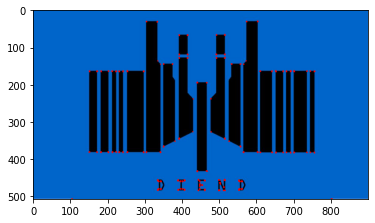

In [168]:
plt.imshow(cv.cvtColor(harris(diend),cv.COLOR_BGR2RGB))

### SHI-TOMASI

O metodo de Shi-Tomasi foi idealizado a partir do método porposto por Harris, e sugere uma pequena alteração no modo de calcular o valor de R (), onde ao invés de utilizar os valores de determinate e do traço, simplesmente o menor valor entre os autovalores da matriz é escolhido como resultado, assim:

R=min(λ1,λ2)

Onde se o resultado for maior que um certo valor de threshold, será considerado como *corner*

In [169]:
def shi_tomasi(img):
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  corners = cv.goodFeaturesToTrack(gray,25,0.01,10)
  corners = np.int0(corners)
  for i in corners:
      x,y = i.ravel()
      cv.circle(img,(x,y),3,(0,0,255),-1)
  return img

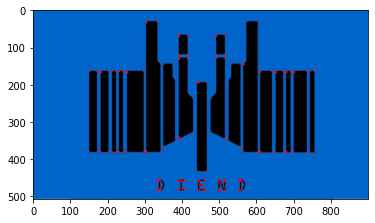

(<matplotlib.image.AxesImage at 0x7fcd0fdf5400>, None)

In [170]:
plt.imshow(cv.cvtColor(shi_tomasi(diend), cv.COLOR_BGR2RGB)),plt.show()

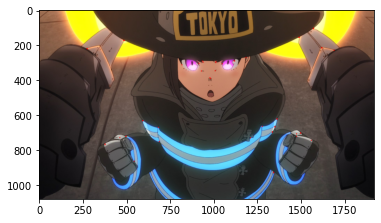

(<matplotlib.image.AxesImage at 0x7f978e2a7cc0>, None)

In [ ]:
plt.imshow(cv.cvtColor(shi_tomasi(maki), cv.COLOR_BGR2RGB)),plt.show()

### SUSAN - Smallest Univalue Segment Assimilating Nucleus

A detecção de *corners* proposta em SUSAN é uma abordagem diferente das vistas em Harris e Shi-Tomasi, dessa vez a ideia é de usar uma "Mascara" ao inves de uma janela, cuja forma é "circular" (que engloba 37 pixels) e o pixel analisado é o centro, nessa mascara todos os pixels que não são o central tem seu brilho comparado ao do nucleo e, utilizando um valor de threshold, será determinado se esse pixel do meio é ou não um *corner*

Os calculos utilizados são:

c(m) = e^-(((I(m) - I(m0))/t)^6)

Onde I(m) é a intensidade de um pixel m, m0 é o núcleo e t é threshold de diferença do brilho

Depois é feito um somatório dos c (n(M)) e valor do pixel na saída será decidido por:

{ g- n(M)   se n(M) < g
{ 0         caso não seja

Onde g é o Threshold geométrico


In [173]:
# codigo utilizado foi adaptado a partir desse repositorio:
# https://github.com/rajatjain3571/Susan-Corner-Detection

def create_susan_mask():
  mask = np.ones((7,7), np.uint8)
  #zerando os 3 valores das quinas para deixar o formato mais "arredondado"
  mask[0,0], mask[0,1], mask[0,5], mask[0,6], mask[1,0], mask[1,6] = 0, 0, 0, 0, 0, 0
  mask[6,0], mask[6,1], mask[6,5], mask[6,6], mask[5,0], mask[5,6] = 0, 0, 0, 0, 0, 0
  return mask

def susan(img, t=10, g=5):
  img = img.astype(np.float64)
  mask = create_susan_mask()
  exit = img*0

  for i in range(3, len(img)-3):
    for j in range(3, len(img[i])-3):
      subm = np.array(img[i-3:i+4, j-3:j+4])
      subm = subm[mask==1] #somente os pixels equivalentes a onde for 1 na mascara
      nucleus = img[i][j] #pixel central a ser analisado
    
      c = np.exp(-((subm - nucleus)/t)**6)
      n = np.sum(c)

      if (n <= g): exit[i][j] = g-n
      else: exit[i][j] = 0
  return exit

def plot_image(image,title):
	plt.figure()

	plt.title(title)
	plt.imshow(image,cmap = 'gray')

	plt.show()

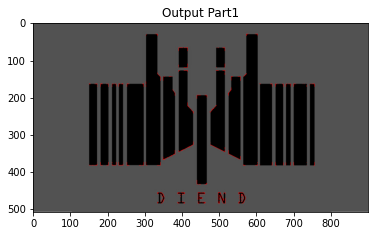

In [174]:
img=cv.imread("diend2.jpg",0)
output1 = susan(img, 10, 7)
finaloutput1 = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
finaloutput1[output1 != 0] = [255, 0, 0]
plot_image(finaloutput1, "Output Part1")

# QUESTÃO 02

Descritores utilizados:
* SIFT
* ORB
* HoG

### SIFT - Scale Invariant Feature Transform

O SIFT é um descritor criado a partir da ideia do detector de Harris para torná-lo invariante a escala. O SIFT usa uma tecnica chamada "Diferença das Gaussianas", que é uma aproximação mais barata da LoG, é criada uma pirâmide gaussiana onde o pixel é comparado a sua vizinhança e a ele mesmo nas escalas proximas para determinar se ele é o melhor *keypoint* na escala. Os melhores são selecionados, depois é calculado seus gradientes e utilizados para montar histogramas.




Pegue uma janela de 16x16 pixels ao redor da feature

calcula a orientação da aresta pra cada pixel (vetor gradiente e rotaciona 90 graus)

descarte as arestas mais fracas

crie histogramas das mais fortes




consegue 



In [186]:
def sift(img):
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create()
  kp = sift.detect(gray,None)
  #img=cv.drawKeypoints(gray,kp,img)
  img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  return img

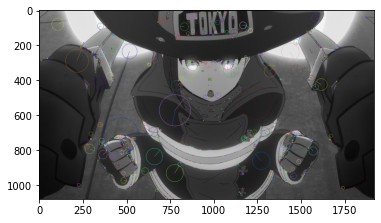

(<matplotlib.image.AxesImage at 0x7fcd12318198>, None)

In [187]:
img = cv.imread('maki.jpg')
plt.imshow(sift(img)),plt.show()

### ORB - Oriented FAST and Rotated BRIEF

ORB foi proposto como uma alternativa ao SIFT e ao SURF, devido as patentes, e funciona como um misto entre duas tecnicas: FAST para parte de detecção e BRIEF para a descrição, sendo que ORB implementa algumas melhorias nesses dois algoritmos para que corrigir seus pontos fracos.

In [177]:
def orb(img):
  orb = cv.ORB_create()
  kp, desc = orb.detectAndCompute(img,None)
  img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
  return img2

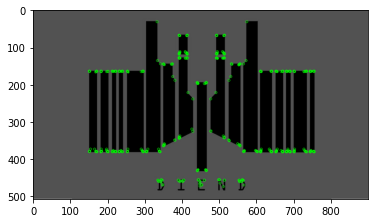

(<matplotlib.image.AxesImage at 0x7fcd12394b00>, None)

In [179]:
#implementação forecida pelo OpenCV
img = cv.imread('diend2.jpg',0)
img2 = orb(img)
plt.imshow(img2), plt.show()

BRIEF

algo

### HoG - Histogram of Gradients

Esse descritor utiliza dos gradientes calculados nos pontos para gerar conjuntos de histogramas com várias direções de gradientes.

O processo dela precisa que uma janela da imagem seja isolada utilizando as proporções de 1:2, para que possa ser reduzida a dimensão de 64x128 pixels, onde o valor do Gradiente é calculado para cada pixel pra depois serem reagrupados em uma matriz de 8x16, onde cada quadrado da matriz possui 8x8 pixels.

Um histograma de bins = 20 é montado e a partir dos valores da direção, a magnitude equivalente é atribuida para o respectivo bin ou distribuido entre os correspondentes ao intervalo, cada bloco retorna um vetor 9 elementos e os valores são normalizados.

Esse descritor é bastante usado para análise e detecção de pedestres

In [190]:
def get_hists(subm, dirs, mags):
  hist = [0,0,0,0,0,0,0,0,0]
  for i in range(8):
    for j in range(8):
      dir, mag = dirs[i][j]%180, mags[i][j]
      div = (dir//20)%9
      if (dir%20==0):
        hist[int(div)] += mag
      else:
        next = (div + 1)
        count_to_next = (next*20)-dir
        p = 1/(20/count_to_next)
        next = next%9
        hist[int(div)] += p*mag
        hist[int(next)] += (1-p)*mag
    return hist


def normalize(vector):
  norm_vec = np.array(vector)
  n = np.linalg.norm(t)
  for i in range(len(vector)):
    norm_vec[i] = vector[i]/n
  return norm_vec


def hog(img):
  img = np.float32(img) / 255.0
  #sobel
  gx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=1)
  gy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=1)
  #magnitude e direções
  mag, angle = cv.cartToPolar(gx, gy, angleInDegrees=True)
  hists = []
  for i in range(0, len(img), 8):
    for j in range(0, len(img[i]), 8):
      subm = np.array(img[i:i+8, j:j+8])
      hists.append(get_hists(subm, angle, mag))
  print(hists)
    

In [194]:
#Codigo de HoG
#Retirado do site: https://www.learnopencv.com/histogram-of-oriented-gradients/

# Python gradient calculation 

# Read image
img = cv.imread('maki.jpg',0)
img = np.float32(img) / 255.0

# Calculate gradient 
gx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=1)
gy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=1)

# Python Calculate gradient magnitude and direction ( in degrees ) 
mag, angle = cv.cartToPolar(gx, gy, angleInDegrees=True)
#plt.imshow(cv.cvtColor(gx, cv.COLOR_BGR2RGB)),plt.show()
print(angle)
hog(img)

[[  0.         0.         0.       ... 180.         0.         0.      ]
 [270.       303.6832   333.4329   ...  90.        90.        90.      ]
 [270.       306.8637   306.8637   ...   0.       270.       270.      ]
 ...
 [ 90.        90.        90.       ... 106.70217  108.438675  90.      ]
 [  0.         0.         0.       ... 180.       108.438675  90.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]]
[[0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779078722, 0, 0, 0, 0, 0, 0, 0, 0], [0.0001076508779

In [142]:
for i in range(1,10, 3):
  print(i)

1
4
7


# QUESTÃO 03

Algoritmos de Matching:
*      Brute Force com ORB
*      Brute Force com SIFT
*      FLANN(Fast Library for Approximate Nearest Neighbors) Matcher


Fonte dos códigos utilizados: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher

### Brute Force com ORB

In [87]:
img1 = cv.imread('jojo02.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('livros.jpg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

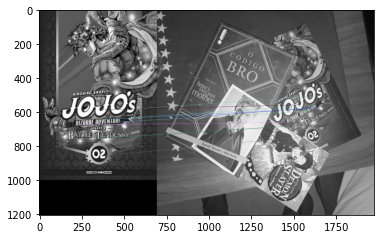

(<matplotlib.image.AxesImage at 0x7fcd19ab3278>, None)

In [88]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### Brute Force com SIFT

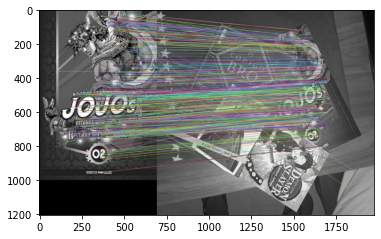

(<matplotlib.image.AxesImage at 0x7fcd1b5345c0>, None)

In [91]:
img1 = cv.imread('jojo02.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('livros.jpg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### FLANN - Fast Library for Approximate Nearest Neighbors

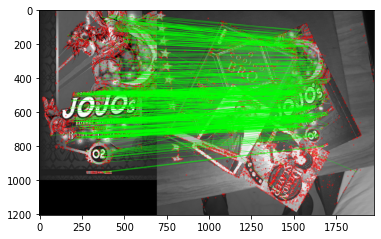

(<matplotlib.image.AxesImage at 0x7fcd1b576d68>, None)

In [89]:
img1 = cv.imread('jojo02.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('livros.jpg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

# QUESTÃO 04

# QUESTÃO 05

Unicidade de pontos de interesse se refere a cada ponto ser único, já que na hora de fazer o *matching* entre duas imagens, dois pontos de mesmo valor poderiam confundir o programa, que faria com que ele unisse os pontos errados nas duas imagens



INSERIR EXEMPLOS

# QUESTÃO 06

# Referencias

https://www.learnopencv.com/histogram-of-oriented-gradients/

https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83

https://github.com/rajatjain3571/Susan-Corner-Detection

https://users.fmrib.ox.ac.uk/~steve/susan/susan/node13.html